# Step 2: Digitize the simulated data

In [1]:
distances = [15, 35]
doubleplanes = [8, 12, 30]
energies = [200, 600, 1000]
erels = [100, 500]
neutrons = [1, 2, 3, 4, 5, 6]
physicss = ["bert", "bic", "inclxx"]
scenarios = ["air", "vacuum"]

## a) Digitize

In [3]:
import joblib
from digitization import digitization

joblib.Parallel(n_jobs=-1, backend="loky", verbose=1)(
    joblib.delayed(digitization)(
        distance=distance,
        doubleplane=doubleplane,
        energy=energy,
        erel=erel,
        neutron=neutron,
        physics=physics,
        scenario=scenario,
    )
    for distance in distances
    for energy in energies
    for doubleplane in doubleplanes
    for neutron in neutrons
    for erel in erels
    for physics in physicss
    for scenario in scenarios
);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed: 38.4min finished


## b) Check digitization: Number of events

In [4]:
import pandas as pd
import numpy as np
import joblib
import os
import ROOT

ROOT.ROOT.EnableThreadSafety()

Welcome to JupyROOT 6.16/00


In [5]:
def processed_events(distance, doubleplane, energy, erel, neutron, physics, scenario):
    filepattern = "output/%s-%s/%dm_%ddp_%dAMeV_%dkeV_%dn.%s.root"
    filename = filepattern % (
        physics.lower(),
        scenario,
        distance,
        doubleplane,
        energy,
        erel,
        neutron,
        "digi",
    )
    if os.path.isfile(filename):
        try:
            tfile = ROOT.TFile.Open(filename)
            ttree = tfile.Get("evt")
            num_events = int(ttree.GetEntries())
            return (filename, num_events)
        except:
            pass
    return (filename, 0)

In [6]:
evts = pd.DataFrame(
    joblib.Parallel(n_jobs=-1, backend="multiprocessing", verbose=1)(
        joblib.delayed(processed_events)(
            distance=distance,
            doubleplane=doubleplane,
            energy=energy,
            erel=erel,
            neutron=neutron,
            physics=physics,
            scenario=scenario,
        )
        for distance in distances
        for energy in energies
        for doubleplane in doubleplanes
        for neutron in neutrons
        for erel in erels
        for physics in physicss
        for scenario in scenarios
    )
)

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 1186 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 1296 out of 1296 | elapsed:   16.0s finished


In [7]:
pd.options.display.max_rows = 5
evts.columns = ["File", "Events"]
evts.sort_values(by=["Events", "File"], ascending=[True, True], inplace=True)
evts.style.hide_index().format({"Events": "{:d}"})
display(evts)

,File,Events
504,output/bert-air/15m_12dp_1000AMeV_100keV_1n.di...,10000
516,output/bert-air/15m_12dp_1000AMeV_100keV_2n.di...,10000
...,...,...
923,output/inclxx-vacuum/35m_8dp_600AMeV_500keV_5n...,10000
935,output/inclxx-vacuum/35m_8dp_600AMeV_500keV_6n...,10000


## c) Check digitization: Histrograms for sample file

In [12]:
def digidata(distance, doubleplane, energy, erel, nmax, physics, scenario):
    filepattern = "output/%s-%s/%dm_%ddp_%dAMeV_%dkeV_%dn.%s.root"

    t = []
    for neutron in range(1, nmax + 1):
        filename = filepattern % (
            physics.lower(),
            scenario,
            distance,
            doubleplane,
            energy,
            erel,
            neutron,
            "digi",
        )
        tfile = ROOT.TFile.Open(filename)
        ttree = tfile.Get("evt")
        for event in ttree:
            # nPN: Number of incoming primary neutrons
            nIn = neutron
            # nPP: Number of primary neutrons with an energy deposition in NeuLAND
            nPP = event.NeulandPrimaryPoints.GetEntries()
            # nPH: Number of hits that correspond to a energy deposition of a primary neutron
            nPH = event.NeulandPrimaryHits.GetEntries()
            # nHits: Number of hits
            num_hits = event.NeulandHits.GetEntries()
            # nClus: Number of clusters
            num_clusters = event.NeulandClusters.GetEntries()
            # Edep: Total deposited (detected) energy
            # FIXME: why are there nans !?
            edep = round(sum([np.nan_to_num(hit.GetE()) for hit in event.NeulandHits]))

            t.append([nIn, nPP, nPH, num_hits, num_clusters, edep])

    df = pd.DataFrame(t)
    df.columns = ["nIn", "nPP", "nPH", "num_hits", "num_cluster", "edep"]
    return df

In [13]:
data = digidata(
    distance=15,
    doubleplane=30,
    energy=600,
    erel=500,
    nmax=6,
    physics="inclxx",
    scenario="vacuum",
)

In [14]:
pd.options.display.max_rows = 5
data.style.hide_index()
display(data)

,nIn,nPP,nPH,num_hits,num_cluster,edep
0,1,1,1,8,8,150.0
1,1,1,1,11,5,314.0
...,...,...,...,...,...,...
59998,6,6,6,62,28,1338.0
59999,6,6,5,34,17,775.0


In [15]:
nmax = 6
hits = [
    np.histogram(
        data[data["nPH"] == n]["num_hits"], range=(0, 150), bins=150, density=True
    )[0]
    for n in range(1, nmax + 1)
]
clus = [
    np.histogram(
        data[data["nPH"] == n]["num_cluster"], range=(0, 150), bins=150, density=True
    )[0]
    for n in range(1, nmax + 1)
]
edep = [
    np.histogram(
        data[data["nPH"] == n]["edep"], range=(0, 3000), bins=300, density=True
    )[0]
    for n in range(1, nmax + 1)
]

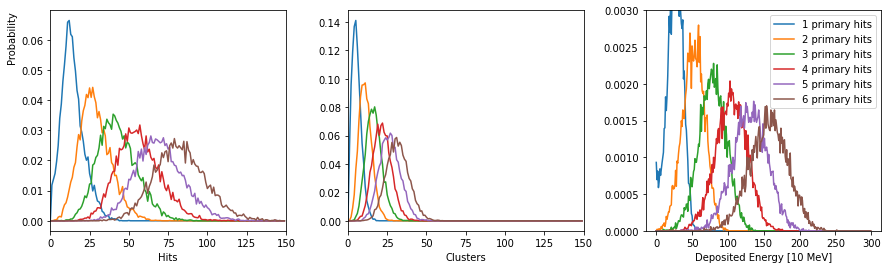

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(2 * 6.224, 2 * (6.224 / 1.618 * 0.5)))

ax1 = fig.add_subplot(131)
ax1.set_xlim(0, 150)
for h in hits:
    ax1.plot(h)
ax1.set_ylabel(r"Probability", horizontalalignment="right", y=1)
ax1.set_xlabel(r"Hits")

ax2 = fig.add_subplot(132)
ax2.set_xlim(0, 150)
for c in clus:
    ax2.plot(c)
ax2.set_xlabel(r"Clusters")

ax3 = fig.add_subplot(133)
ax3.set_ylim(0, 0.003)
for i, e in enumerate(edep, 1):
    ax3.plot(e, label=f"{i} primary hits")
ax3.set_xlabel(r"Deposited Energy [10 MeV]")

ax3.legend()

fig.tight_layout()